Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data

Реализуйте сверточную нейронную сеть с использованием tf.keras или keras. Используйте сверточные, пуллинговые и полносвязанные слои. Обучите на train выборке в течении 10 эпох, оцените качество на отложенной выборке

Добавьте в предыдущую архитектуру слои BatchNorm. Обучите на train выборке в течении 10 эпох, оцените качество на отложенной выборке

Создайте модель ResNet 50 (https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50), инициализированную случайными весами, и обучите ее на train выборке в течении 10 эпох, оцените качество на отложенной выборке

Создайте модель ResNet 50, инициализированную весами ImageNet, и обучите ее на train выборке в течении 10 эпох, оцените качество на отложенной выборке

Результат пришлите в виде Jupyter Notebook на github’е или расшаренного Google Colab-блокнота

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.4.0
True


In [13]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files1 = glob('hymenopteazara_data/train/ants/*.jpg')
train_files2 = glob('hymenoptera_data/train/bees/*.jpg')
train_files = train_files1 + train_files2
test_files1 = glob('hymenoptera_data/val/ants/*.jpg')
test_files2 = glob('hymenoptera_data/val/bees/*.jpg')
test_files = test_files1 + test_files2

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('ant') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

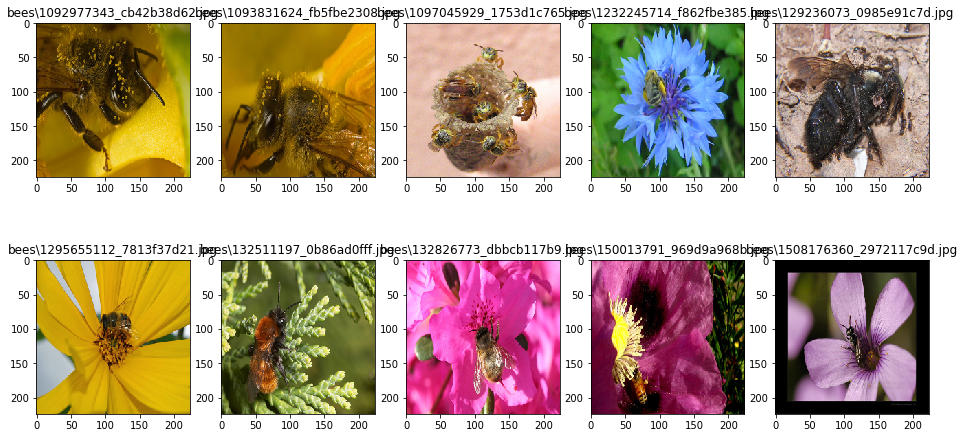

In [14]:

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [15]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58892288/58889256 [==============================] - 11s 0us/step


In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [16]:

# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='bees_vs_ants')

## Выводим архитектуру модели

In [19]:
model.summary()

Model: "bees_vs_ants"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [20]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [21]:

val_samples = 50  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=5,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
5/5 [==============================] - 121s 20s/step - loss: 28.0896 - accuracy: 0.8060 - val_loss: 0.0426 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 59s 13s/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 58s 12s/step - loss: 0.0488 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 61s 13s/step - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 59s 13s/step - loss: 0.0545 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 60s 13s/step - loss: 0.0561 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 62s 13s/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 1.0000
Epoch 8/10
5/5 [=========

In [23]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

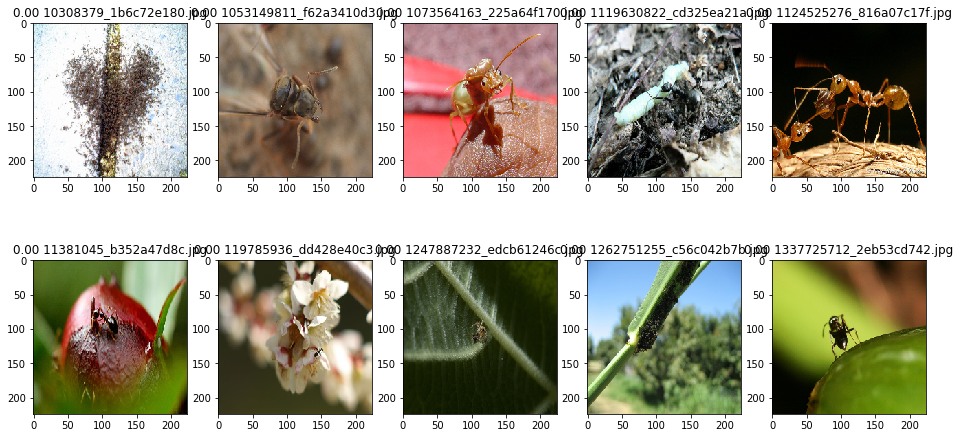

In [24]:

fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Делаем тоже самое с RESNET

In [26]:
from tensorflow.keras.applications import ResNet50

model_2 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94773248/94765736 [==============================] - 31s 0us/step


In [29]:
# фиксируем все веса предобученной сети
for layer in model_2.layers:
    layer.trainable = False

x = model_2.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

ResNet_model = tf.keras.Model(inputs=model_2.input, outputs=x, name='bees_vs_ants')

In [30]:
ResNet_model.summary()

Model: "bees_vs_ants"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [31]:
ResNet_model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [33]:
val_samples = 50
  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
ResNet_model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 44s 4s/step - loss: 0.2278 - accuracy: 0.8623 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 40s 4s/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 38s 4s/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 39s 4s/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 71s 7s/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 76s 8s/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 75s 8s/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 8/10
10/10 [==

In [34]:

test_pred = ResNet_model.predict(
    predict_generator(test_files), steps=len(test_files))

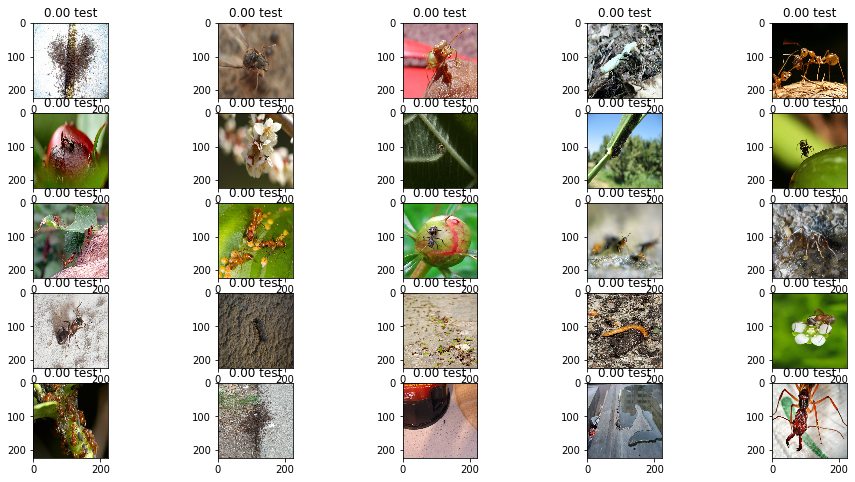

In [56]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:25], test_pred[:25]), 1):
    subplot = fig.add_subplot(5, 5, i)
    subplot.set_title('%.2f %s' % (score, "test"))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)